In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.svm import SVC
import datetime
import pickle

In [2]:
data = pd.read_csv("smoke_detection_iot.csv")
data.sample(5)

Unnamed: 0         UTC  Temperature[C]  Humidity[%]  TVOC[ppb]  \
749           749  1654734080          26.636        54.68          0   
32063       32063  1654768412          18.580        56.05        247   
43843       43843  1654780192          26.630        49.12       1182   
24288       24288  1654757619          -7.516        53.25       1279   
42955       42955  1654779304          27.020        47.61       1157   

       eCO2[ppm]  Raw H2  Raw Ethanol  Pressure[hPa]  PM1.0  PM2.5  NC0.5  \
749          400   12951        19895        939.761   0.22   0.23   1.52   
32063        400   13126        20018        939.568   0.31   0.32   2.10   
43843        400   12921        19438        938.721   1.58   1.64  10.88   
24288        400   13002        19409        938.797   2.21   2.29  15.18   
42955        400   12905        19435        938.715   1.57   1.63  10.81   

       NC1.0  NC2.5    CNT  Fire Alarm  
749    0.237  0.005    749           0  
32063  0.327  0.007   7069           1  
43843  1.696  0.038  18849           1  
24288  2.368  0.053  24288           1  
42955  1.686  0.038  17961           1

In [3]:
data.drop(columns=['Unnamed: 0','CNT'],inplace=True)
def extract_time(x:int):
    time = datetime.datetime.fromtimestamp(x)
    time = time.time()
    return time.hour*3600 + time.minute*60 + time.second + time.microsecond*1e-6
data['UTC'] = data['UTC'].apply(extract_time)
data.sample(5)

UTC  Temperature[C]  Humidity[%]  TVOC[ppb]  eCO2[ppm]  Raw H2  \
30234  33783.0          22.140        48.79          5        400   13266   
53545  68190.0          26.130        47.26        187        445   12761   
57075  46097.0          26.858        44.88         30        415   12847   
19376  19907.0          20.297        53.73       1247        407   12916   
58911  47933.0          -5.115        41.52        125        400   12786   

       Raw Ethanol  Pressure[hPa]  PM1.0  PM2.5  NC0.5  NC1.0  NC2.5  \
30234        20229        939.710   2.90   3.01  19.93  3.108  0.070   
53545        20531        937.349   1.95   2.02  13.40  2.090  0.047   
57075        20754        937.568   1.93   2.00  13.25  2.066  0.047   
19376        19415        938.684   2.00   2.08  13.76  2.146  0.048   
58911        20583        937.340   1.74   1.81  11.98  1.868  0.042   

       Fire Alarm  
30234           1  
53545           0  
57075           0  
19376           1  
58911           0

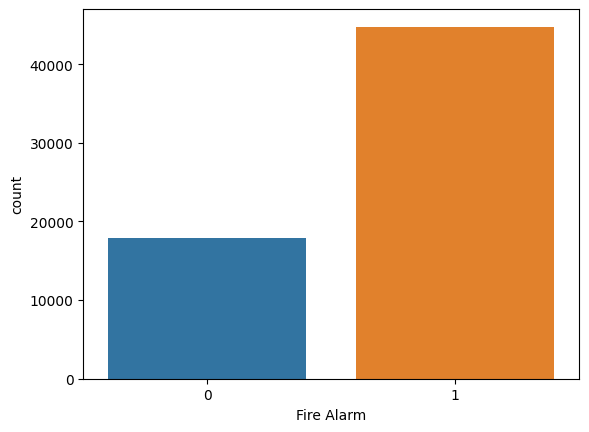

In [4]:
sns.countplot(data=data,x='Fire Alarm')
plt.show()

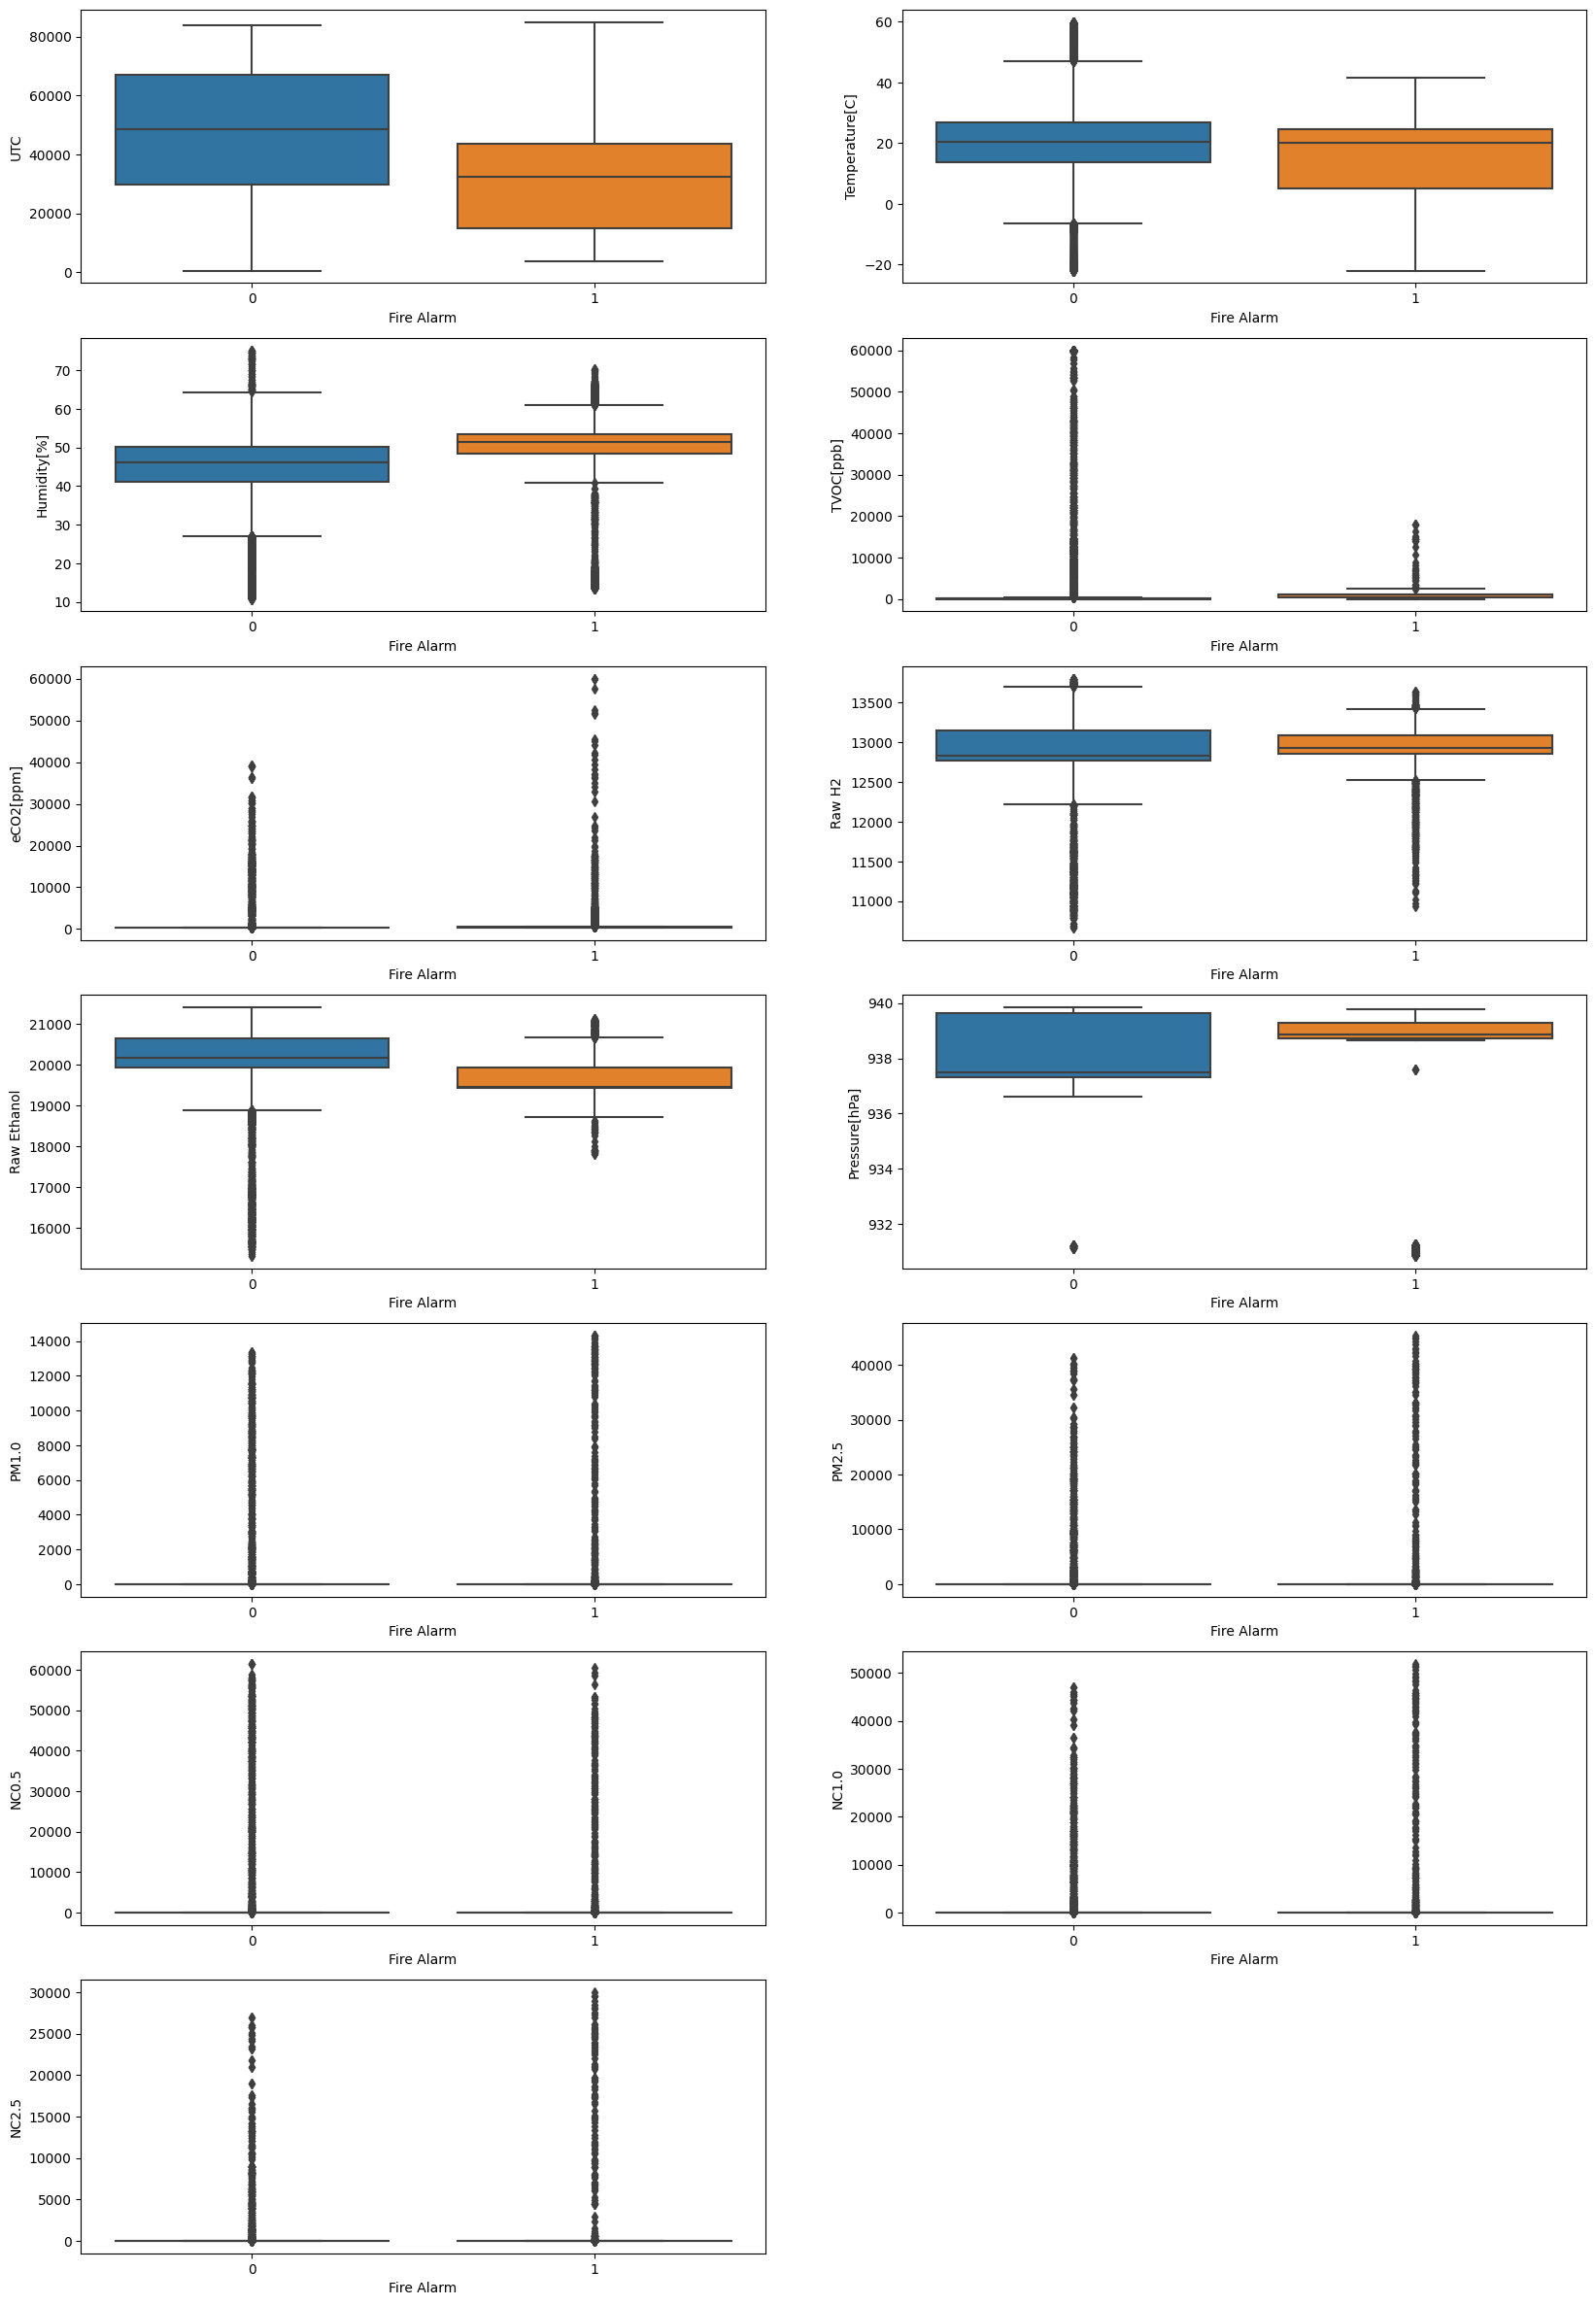

In [5]:
rows = (data.columns.shape[0]-1)//2 + (data.columns.shape[0]-1)%2
cols = 2
plt.figure(figsize=(20,30))
for i,j in enumerate(data.columns.drop('Fire Alarm')):
    plt.subplot(rows,cols,i+1)
    sns.boxplot(y=data[j],x = data['Fire Alarm'])

<Axes: >

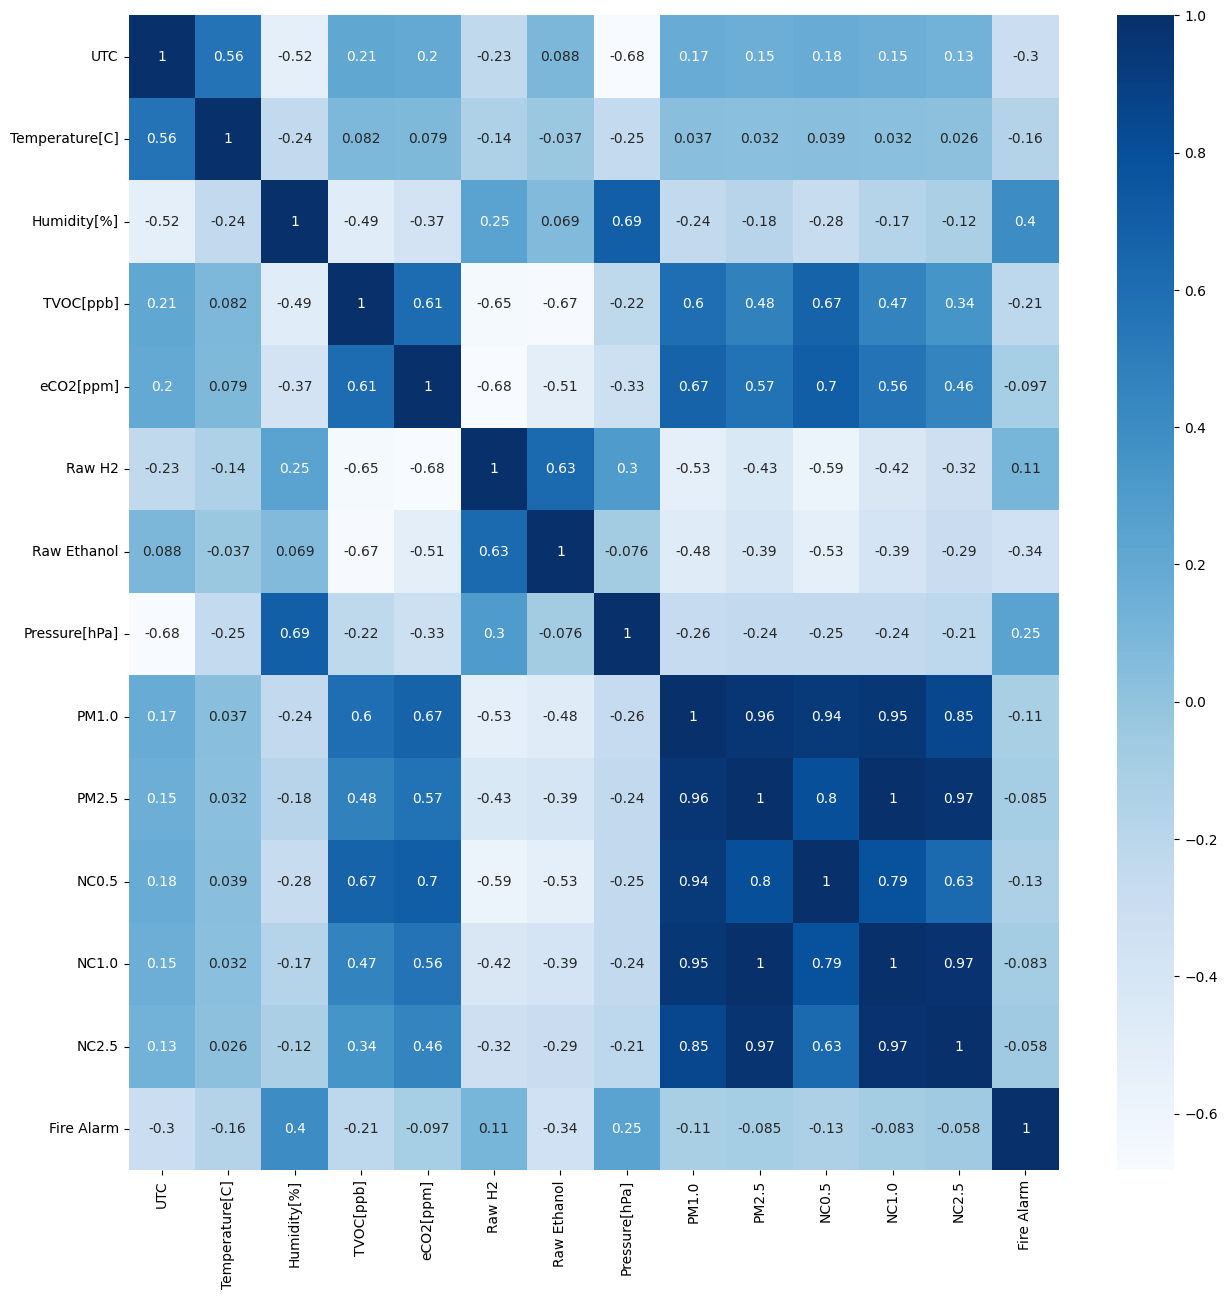

In [6]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(),annot=True,cmap="Blues")

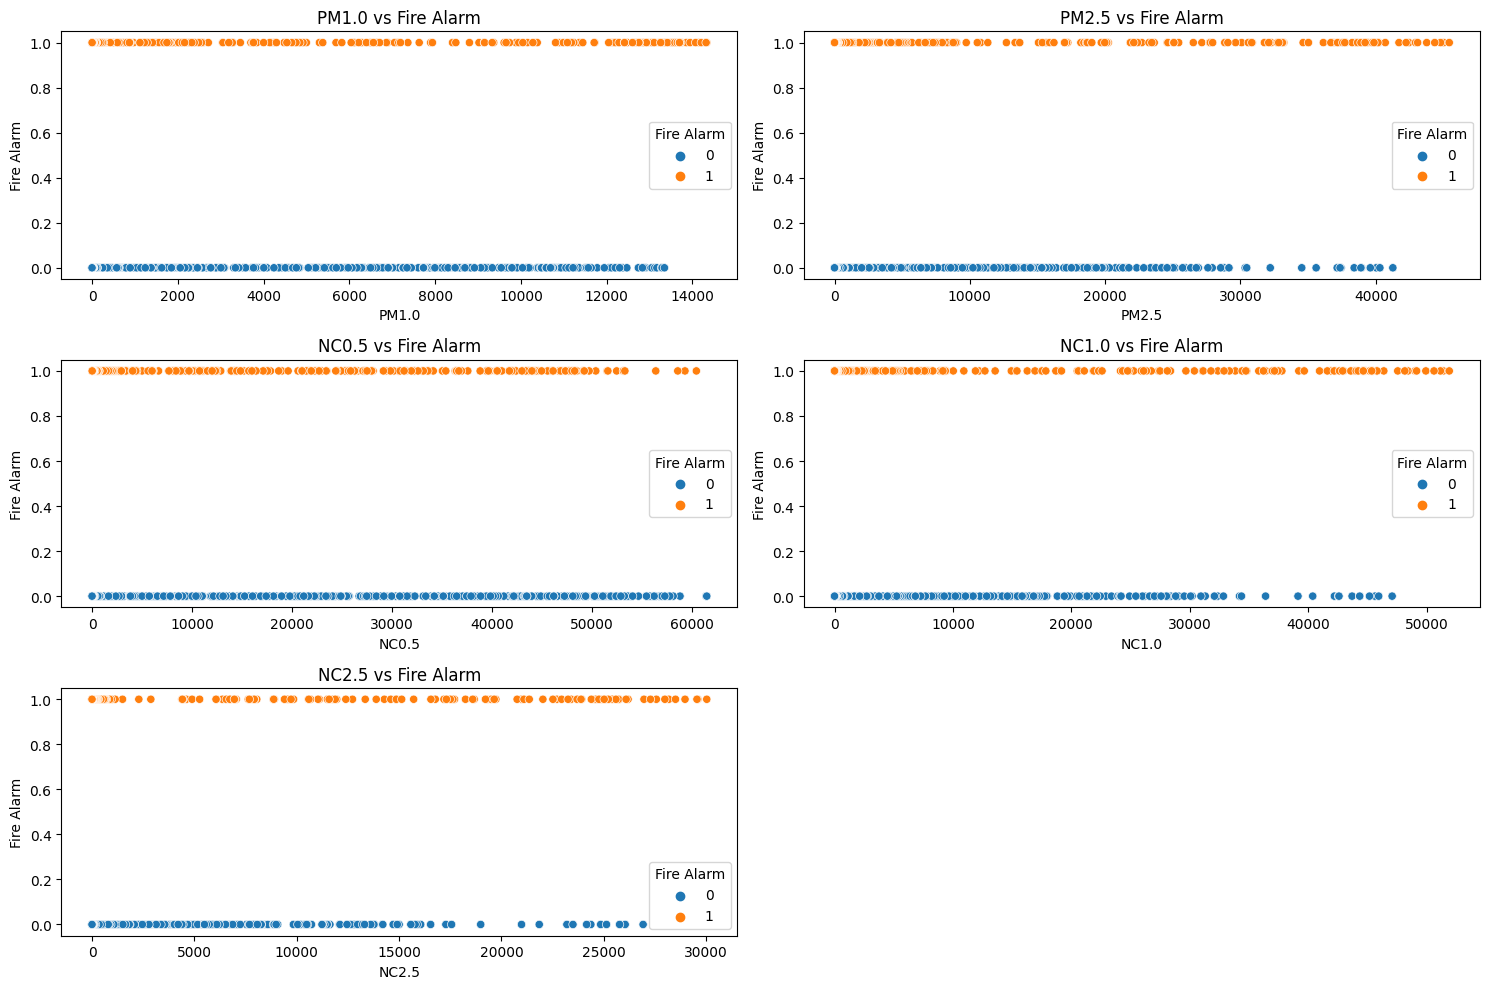

In [7]:
selected_vars = ['PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5']


plt.figure(figsize=(15, 10))

for i, var in enumerate(selected_vars, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=var, y='Fire Alarm', data=data,hue="Fire Alarm")
    plt.title(f'{var} vs Fire Alarm')


plt.tight_layout()

plt.show()

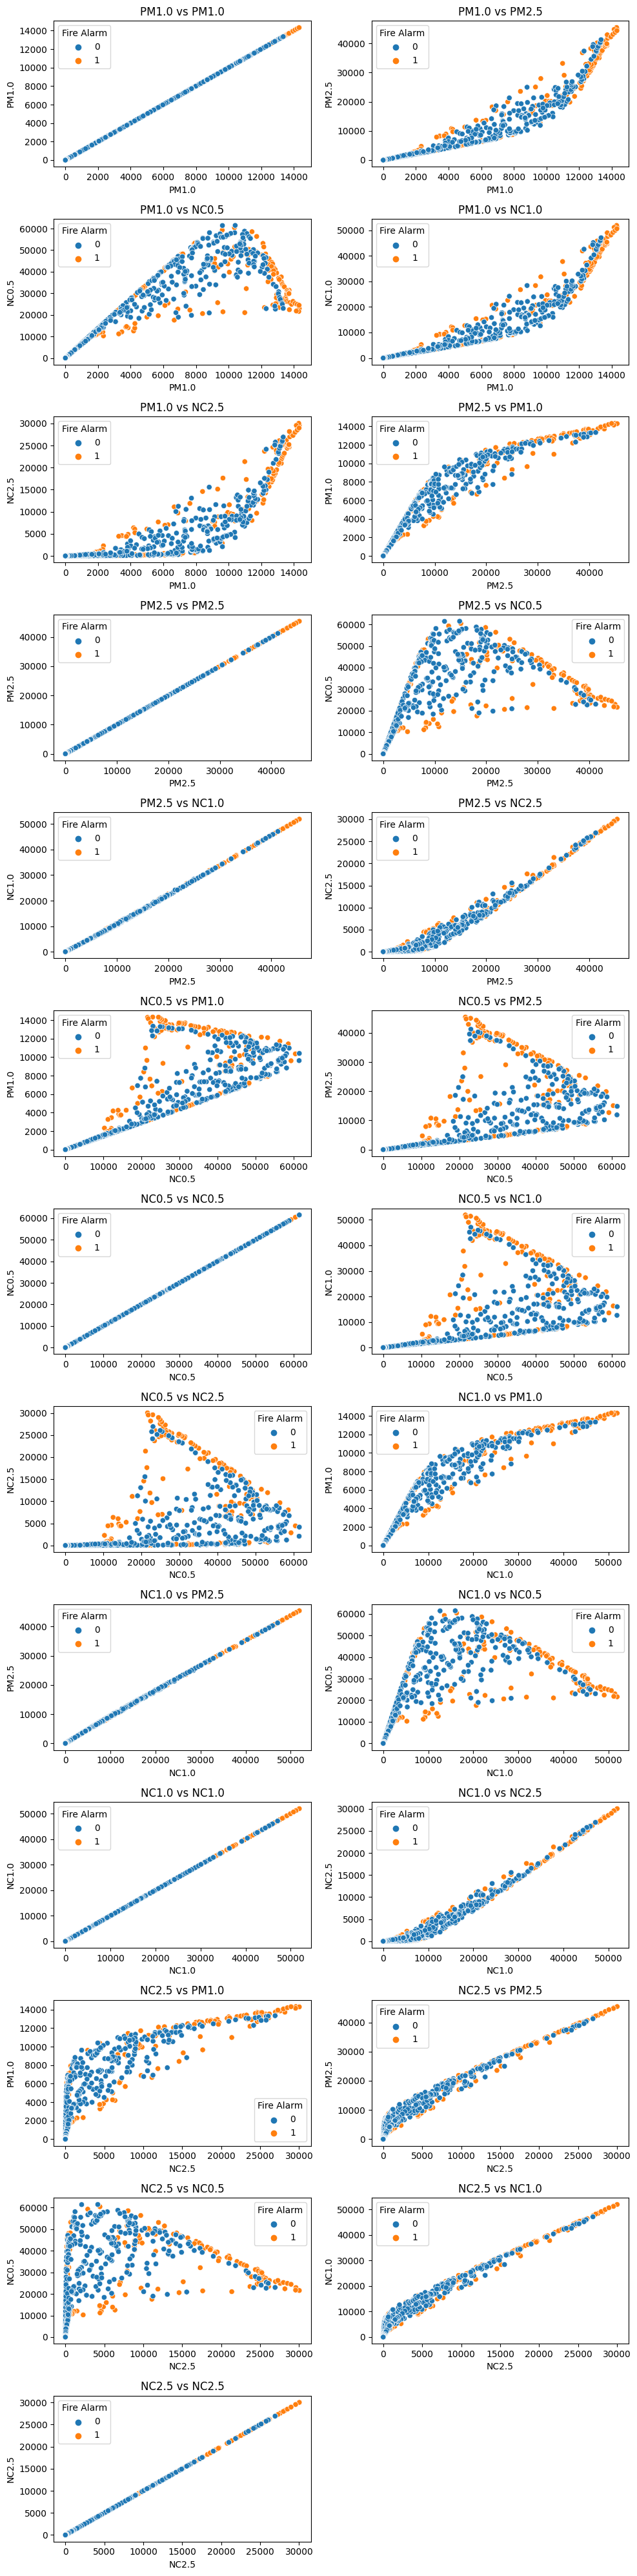

In [8]:
selected_vars = ['PM1.0', 'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5']


plt.figure(figsize=(10,40))

v = 1  # Counter for subplot index

for i in selected_vars:
    for j in selected_vars:
        plt.subplot(13, 2, v)
        sns.scatterplot(x=i, y=j, data=data,hue='Fire Alarm')
        plt.title(f'{i} vs {j}')
        v += 1


plt.tight_layout()


plt.show()

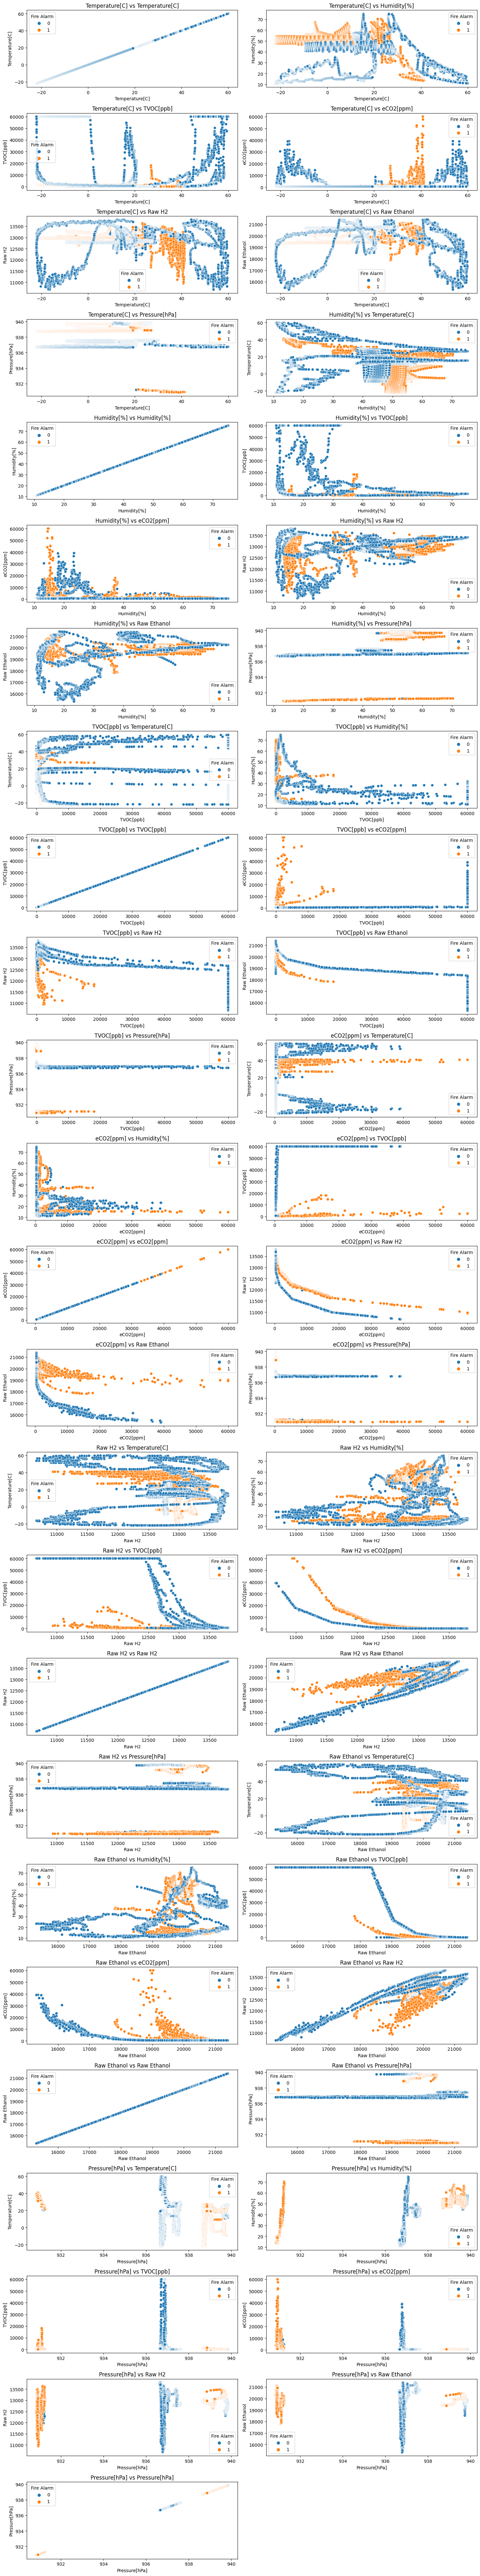

In [9]:
selected_vars = ['Temperature[C]','Humidity[%]','TVOC[ppb]','eCO2[ppm]','Raw H2','Raw Ethanol',	'Pressure[hPa]']


plt.figure(figsize=(15,80))

v = 1  # Counter for subplot index

for i in selected_vars:
    for j in selected_vars:
        plt.subplot(25, 2, v)
        sns.scatterplot(x=i, y=j, data=data,hue='Fire Alarm')
        plt.title(f'{i} vs {j}')
        v += 1


plt.tight_layout()


plt.show()

In [10]:
temp_model = RandomForestClassifier(n_estimators=250)
temp_model.fit(data[data.columns.drop(['Fire Alarm','UTC'])].to_numpy(),data['Fire Alarm'].to_numpy())

RandomForestClassifier(n_estimators=250)

<Axes: >

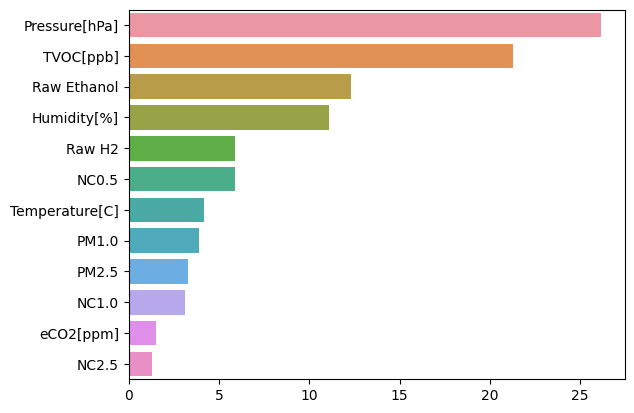

In [11]:
importance = temp_model.feature_importances_*100
order = np.argsort(importance)[::-1]
sns.barplot(x=np.sort(importance)[::-1],y=data.columns.drop(['Fire Alarm','UTC'])[order])

In [12]:
def train_model(models:list,test_x:np.ndarray,test_y:np.ndarray,train_x:np.ndarray,train_y:np.ndarray,eval:dict):
    keys = list(eval.keys())
    for i,j in enumerate(models):
        j.fit(train_x,train_y)
        pred = j.predict(test_x)
        eval[keys[i]]["precision"].append(precision_score(test_y,pred))
        eval[keys[i]]["accuracy"].append(accuracy_score(test_y,pred))
        eval[keys[i]]["recall"].append(recall_score(test_y,pred))
        eval[keys[i]]["f1"].append(f1_score(test_y,pred))



In [14]:
scalar = StandardScaler()
X = data[data.columns.drop(['Fire Alarm','UTC','NC2.5','NC1.0','PM2.5','PM1.0'])].to_numpy()
y = data['Fire Alarm'].to_numpy()
X = scalar.fit_transform(X)
skf = StratifiedKFold(n_splits=7,shuffle=True,random_state=42)
index = skf.split(X,y)
eval = {"log":{"precision":[],"recall":[],"f1":[],"accuracy":[]},"random":{"precision":[],"recall":[],"f1":[],"accuracy":[]},
        "svm":{"precision":[],"recall":[],"f1":[],"accuracy":[]},"KNN":{"precision":[],"recall":[],"f1":[],"accuracy":[]},
        "ada":{"precision":[],"recall":[],"f1":[],"accuracy":[]}, "gradient":{"precision":[],"recall":[],"f1":[],"accuracy":[]}
        }
train_models = [LogisticRegression(max_iter=1000),RandomForestClassifier(),SVC(),KNeighborsClassifier(),AdaBoostClassifier(),GradientBoostingClassifier()]
for train,test in index:
    train_model(train_models,X[test],y[test],X[train],y[train],eval)


In [15]:
summary = {
    "model":[],
    "precision":[],
    "recall":[],
    "f1_score":[],
    "accuracy":[]
}
for i in eval.keys():
    summary["model"].append(i)
    summary["precision"].append(np.mean(eval[i]["precision"]))
    summary["recall"].append(np.mean(eval[i]["recall"]))
    summary["accuracy"].append(np.mean(eval[i]["accuracy"]))
    summary["f1_score"].append(np.mean(eval[i]["f1"]))
pd.DataFrame(summary).style.background_gradient(cmap="Blues")

In [16]:
params_grid = {
    'n_estimators':[100,150,200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features':['log2','sqrt']
}

In [ ]:
model = RandomForestClassifier()
grid_search = GridSearchCV(model,param_grid=params_grid,cv=StratifiedKFold(n_splits=7) ,scoring=['recall', 'precision'],refit="recall",n_jobs=5)
grid_search.fit(X,y)

In [ ]:
new_skf = StratifiedKFold(n_splits=7,shuffle=True,random_state=42)
new_index = new_skf.split(X,y)
j = 1
for train,test in new_index:
    grid_search.best_estimator_.fit(X[train],y[train])
    print("Fold",j)
    print(classification_report(y[test],grid_search.best_estimator_.predict(X[test])))
    j += 1


In [ ]:
grid_search.best_estimator_.fit(X,y)

In [ ]:
pickle.dump(grid_search.best_estimator_,open("../model.pkl","wb"))